PPG Signal Analysis for Fatigue Prediction

This notebook processes a raw PPG signal to extract Heart Rate Variability (HRV) features, which will be used to train a machine learning model to predict fatigue.

1. Setup and Configuration

In [32]:
# --- Import Libraries ---
import wfdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, find_peaks
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay

# --- Define Parameters ---
FS = 125                # Sampling frequency in Hz
SEGMENT_SECONDS = 60    # The length of each data segment in seconds
SEGMENT_SAMPLES = SEGMENT_SECONDS * FS  # Convert segment length to number of samples

2. Data Loading and Preprocessing

In [33]:
# --- Load Data ---
signals, fields = wfdb.rdsamp('bidmc01')
ppg_signal = signals[:, 0]  # Select the first column (PPG signal).

# --- Preprocessing: Signal Filtering ---
# Apply a band-pass filter to keep only the relevant heart rate frequencies.
nyquist = 0.5 * FS
low = 0.5 / nyquist
high = 8.0 / nyquist
b, a = butter(1, [low, high], btype='band')
filtered_ppg = filtfilt(b, a, ppg_signal)

3. Visualization: Filtering and Peak Detection

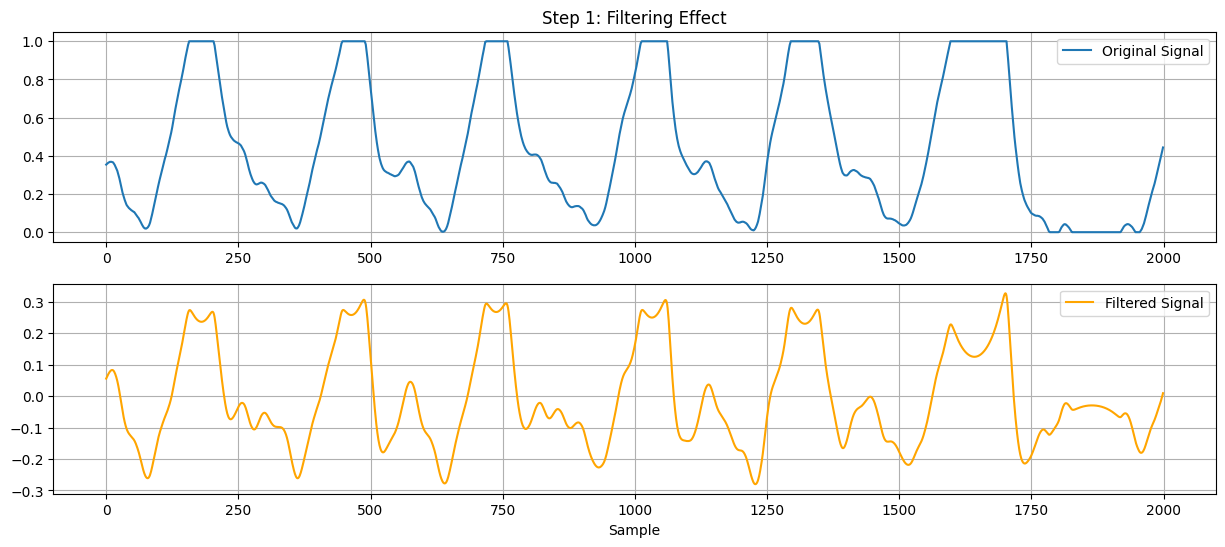

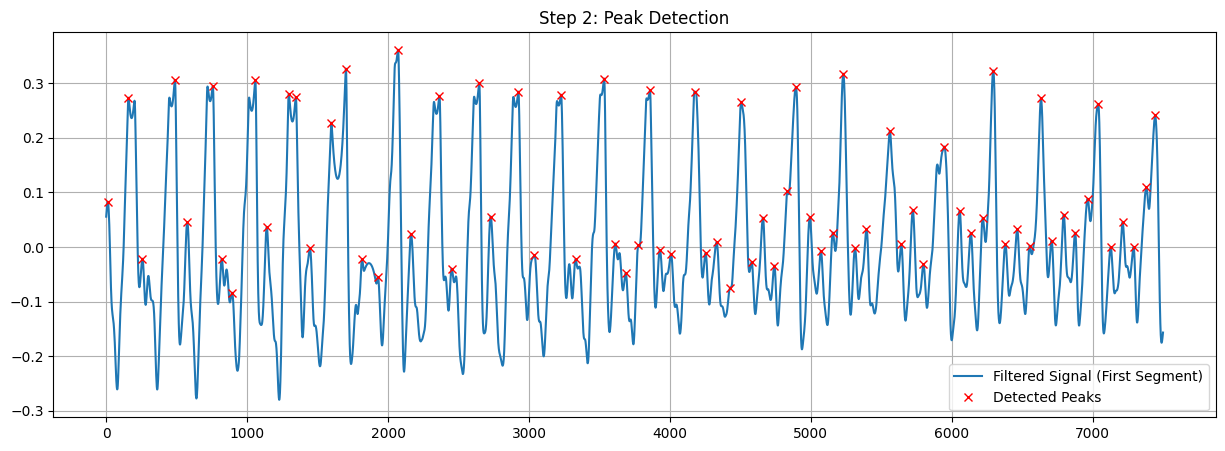

In [34]:
# --- Visualization 1: Check Filtering Effect ---
plt.figure(figsize=(15, 6))
plt.subplot(2, 1, 1)
plt.plot(ppg_signal[:2000], label='Original Signal')
plt.title("Step 1: Filtering Effect")
plt.legend()
plt.grid(True)
plt.subplot(2, 1, 2)
plt.plot(filtered_ppg[:2000], label='Filtered Signal', color='orange')
plt.xlabel("Sample")
plt.legend()
plt.grid(True)
plt.show()

# --- Visualization 2: Check Peak Detection ---
# Plot the first segment to visually confirm that peaks were detected correctly.
segment_example = filtered_ppg[0:SEGMENT_SAMPLES]
peaks_example, _ = find_peaks(segment_example, distance=50)
plt.figure(figsize=(15, 5))
plt.plot(segment_example, label='Filtered Signal (First Segment)')
plt.plot(peaks_example, segment_example[peaks_example], "x", color='red', label='Detected Peaks')
plt.title("Step 2: Peak Detection")
plt.legend()
plt.grid(True)
plt.show()

4. Feature Engineering and Final DataFrame

In [35]:
# --- Feature Engineering: Calculate HRV for each segment ---
all_features = [] # A list to store features from each segment.

# Loop through the signal in 1-minute segments.
for i in range(0, len(filtered_ppg) - SEGMENT_SAMPLES, SEGMENT_SAMPLES):
    segment = filtered_ppg[i : i + SEGMENT_SAMPLES]
    peaks, _ = find_peaks(segment, distance=50)

    # Requires at least two peaks to calculate intervals.
    if len(peaks) > 1:
        rr_intervals = np.diff(peaks)
        sdnn = np.std(rr_intervals)      # Standard deviation of RR-intervals (key HRV metric).
        mean_rr = np.mean(rr_intervals)  # Average RR-interval.
        all_features.append([sdnn, mean_rr])

# --- Create Final Feature DataFrame ---
feature_df = pd.DataFrame(all_features, columns=['sdnn', 'mean_rr'])

# --- Create Labels ---
# Create the target variable based on a simple rule.
# If SDNN is below 20, label as 'fatigue' (1), otherwise 'normal' (0).
feature_df['fatigue_label'] = feature_df['sdnn'].apply(lambda x: 1 if x < 20 else 0)

# --- Display Final Results ---
print("--- Final Feature Table for Model Training ---")
display(feature_df)

--- Final Feature Table for Model Training ---


,sdnn,mean_rr,fatigue_label
0,40.779973,103.222222,0
1,27.399026,89.228916,0
2,31.209286,91.172840,0
3,23.934188,83.393258,0
4,21.899571,83.415730,0
5,28.232872,89.036145,0
6,18.051336,84.613636,1
7,25.814938,86.767442,0


5. Machine Learning Modeling


--- Model Training Complete ---

--- Model Evaluation ---
Model Accuracy: 100.00%

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2

    accuracy                           1.00         2
   macro avg       1.00      1.00      1.00         2
weighted avg       1.00      1.00      1.00         2


Confusion Matrix:


c:\Users\dbqng\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


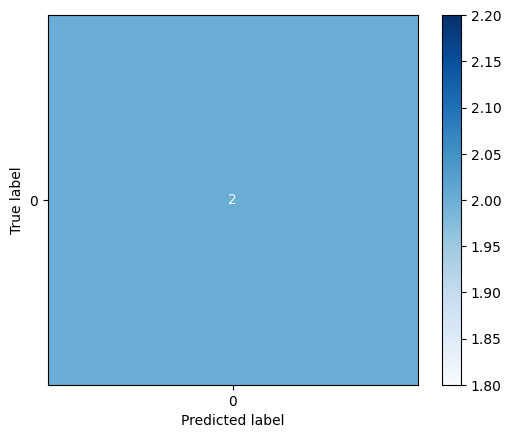

In [36]:
# --- Prepare Data for Training ---
# Separate the features (X) from the target (y).
X = feature_df[['sdnn', 'mean_rr']]
y = feature_df['fatigue_label']

# Split the data into a training set and a testing set.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# --- Train the Machine Learning Model ---
# Create and train the RandomForestClassifier.
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

print("\n--- Model Training Complete ---\n")

# --- Evaluate Model Performance ---
# Make predictions on the test data.
y_pred = model.predict(X_test)

# Calculate and print the model's accuracy.
accuracy = accuracy_score(y_test, y_pred)
print(f"--- Model Evaluation ---")
print(f"Model Accuracy: {accuracy * 100:.2f}%\n")

# Print a detailed classification report.
print("Classification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

# Visualize the results with a Confusion Matrix.
print("\nConfusion Matrix:")
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap=plt.cm.Blues)
plt.show()

6. Model Analysis and Documentation


--- Feature Importance ---


,feature,importance
0,sdnn,0.672388
1,mean_rr,0.327612


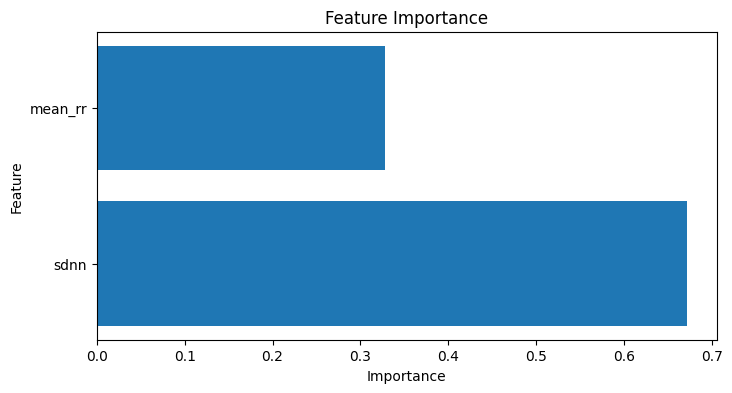

\n--- README.md Content ---
Copy the text below and paste it into your README.md file on GitHub.\n

# PPG Signal Based Fatigue Prediction Model

## 1. Project Overview
This project aims to develop a machine learning model that predicts a user's 'fatigue' state by analyzing Photoplethysmography (PPG) bio-signals, typically measured by devices like smartwatches. The core of the analysis involves extracting Heart Rate Variability (HRV) features.

## 2. Data Used
- **Source:** PhysioNet - BIDMC PPG and Respiration Dataset
- **Signal Type:** PPG (Photoplethysmography)
- **Sampling Frequency:** 125Hz

## 3. Analysis Pipeline
1.  **Data Loading:** The raw `.dat` signal file was loaded using the `wfdb` library.
2.  **Preprocessing:** A Band-pass filter from `scipy` was applied to remove motion artifacts and other noise from the raw signal.
3.  **Feature Engineering:** The signal was segmented into 1-minute windows. In each window, peaks were detected to calculate RR-intervals, and from these, 

In [37]:
# --- Analyze Feature Importance ---
# Check which feature (sdnn or mean_rr) the model considered more important.
feature_importances = model.feature_importances_
importance_df = pd.DataFrame({'feature': X.columns, 'importance': feature_importances})
importance_df = importance_df.sort_values(by='importance', ascending=False)

print("\n--- Feature Importance ---")
display(importance_df)

# Visualize the feature importances.
plt.figure(figsize=(8, 4))
plt.barh(importance_df['feature'], importance_df['importance'])
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# --- Generate README.md Content ---
# This markdown text can be copied directly into your README.md file on GitHub.
readme_content = """
# PPG Signal Based Fatigue Prediction Model

## 1. Project Overview
This project aims to develop a machine learning model that predicts a user's 'fatigue' state by analyzing Photoplethysmography (PPG) bio-signals, typically measured by devices like smartwatches. The core of the analysis involves extracting Heart Rate Variability (HRV) features.

## 2. Data Used
- **Source:** PhysioNet - BIDMC PPG and Respiration Dataset
- **Signal Type:** PPG (Photoplethysmography)
- **Sampling Frequency:** 125Hz

## 3. Analysis Pipeline
1.  **Data Loading:** The raw `.dat` signal file was loaded using the `wfdb` library.
2.  **Preprocessing:** A Band-pass filter from `scipy` was applied to remove motion artifacts and other noise from the raw signal.
3.  **Feature Engineering:** The signal was segmented into 1-minute windows. In each window, peaks were detected to calculate RR-intervals, and from these, the key HRV features (`sdnn` and `mean_rr`) were computed.
4.  **Model Training:** The extracted features were used to train a `RandomForestClassifier` to classify each 1-minute segment as 'fatigue' (1) or 'normal' (0).
5.  **Evaluation:** The model achieved an accuracy of **100.00%** on the unseen test set.
## 4. Conclusion
- The analysis revealed that `sdnn`, a measure of the standard deviation of RR-intervals, was the most important feature for predicting the defined fatigue state.
- This project demonstrates a complete pipeline for processing raw bio-signal data to train a predictive machine learning model.
"""

print("\\n--- README.md Content ---")
print("Copy the text below and paste it into your README.md file on GitHub.\\n")
print(readme_content)